In [26]:
%load_ext autoreload
%autoreload 2 # pour que les changements dans les modules soient pris en compte automatiquement

from google.colab import drive
drive.mount('/content/drive') # pour monter notre drive au notebook
project_path = '/content/drive/MyDrive/lewagon-deepdive/'

import sys; sys.path
sys.path.append('/content/drive/MyDrive/lewagon-deepdive/lewagon-deepdive') # pour pouvoir importer nos modules pratiques à utiliser dans les notebooks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
from dataset import *
from data_preproc import *
from plot_loss_accuracy import plot_loss_accuracy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import joblib

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve

from tensorflow.keras import layers,models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.metrics import AUC
from tensorflow.keras import regularizers
from tensorflow.math import confusion_matrix


# MODEL PARAMS

In [28]:
model_nb=12 # IMPORTANT!

In [29]:
families_to_keep=[]
species_to_keep=['BA2A','AC2A','AC1F','BE3C','BD15L','BD5A','AA1A','CB1A','BD6A','BD15F','BD4A','BB1A','CC12G','CC2A',
          'BD15B','BE7A','BD15A','BB2A','AA3A','CC14A','BD6B','AA3B','BE9A','CC5A','CC4A','BD17A','BD19D',
          'BD15C','AC1A','BD3B','BD10A']
min_duration=1
target_time=5
target='species' # or species

## Generate Dataframe with specific features

In [30]:
df= get_dataset('/content/drive/MyDrive/lewagon-deepdive/raw_data/watkins_sound_list_extended.csv',families_to_keep= families_to_keep,species_to_keep=species_to_keep,min_duration=min_duration)

### Class distribution

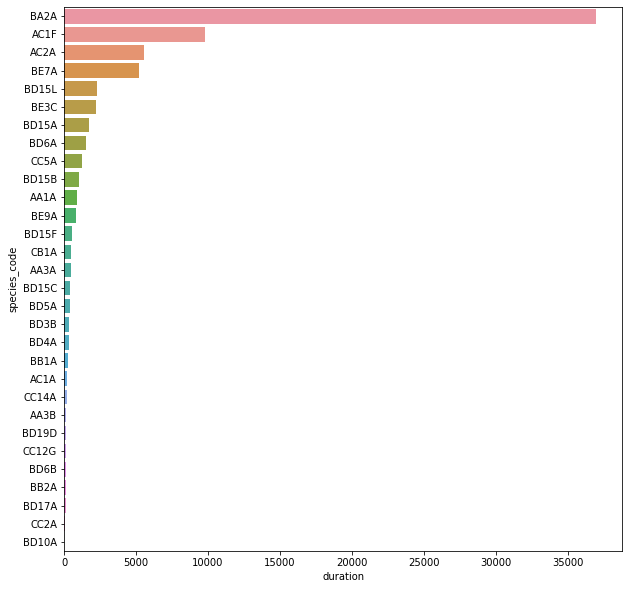

In [31]:
df_duration = df.groupby(['species_code']).sum()
df_duration.sort_values(by='duration', ascending=False, inplace = True)


plt.figure(figsize=(10,10))
sns.barplot(x=df_duration.duration, y=df_duration.index);

In [33]:
over_r =['BA2A','AC2A','AC1F','BE7A'] # defining over-represented classes
under_r =['BE3C','BD15L','BD5A','AA1A','CB1A','BD6A','BD15F','BD4A','BB1A','CC12G','CC2A',
          'BD15B','BD15A','BB2A','AA3A','CC14A','BD6B','AA3B','BE9A','CC5A','CC4A','BD17A','BD19D',
          'BD15C','AC1A','BD3B','BD10A'] # defining under-represented classes

# Preprocessing

## Generating list of tuples (audio data, code)

In [34]:
input_list= get_list_of_tuples(df, '/content/drive/MyDrive/lewagon-deepdive/raw_data/Watkins_all_cuts', target=target, sr=44_100, nb_rows=None)

## Generating Train, Val and Test sets

In [ ]:
train_set,val_set, test_set = enhanced_dataset_split(input_list,df, test_size=0.2,threshold=0.5,target=target) # train val test split

below_train,above_train = split_above_below(train_set, target_time,44100) # split between files above and below target_time
below_test, above_test = split_above_below(test_set, target_time,44100)
below_val, above_val = split_above_below(val_set, target_time,44100)

above_train_samples = train_split_above_samples(above_train,over_r,under_r, target_time, 44100,audio_manipulation=True) # preprocessing samples above target_time
below_train_samples = train_split_below_samples(below_train,over_r,under_r, target_time, 44100, audio_manipulation=True) # preprocessing samples below target_time

above_val_samples = val_test_split_above_samples(above_val, target_time, 44100)
below_val_samples = val_test_split_below_samples(below_val, target_time, 44100)

above_test_samples = val_test_split_above_samples(above_test, target_time, 44100)
below_test_samples = val_test_split_below_samples(below_test, target_time, 44100)

preproc_train_set= final_set(above_train_samples,below_train_samples) # compiling final set
preproc_val_set= final_set(above_val_samples,below_val_samples)
preproc_test_set= final_set(above_test_samples,below_test_samples)

In [ ]:
len(below_train_samples),len(above_train_samples)

## Removing samples for over-represented categories

### Train set

In [32]:
# temp_df=pd.DataFrame(preproc_train_set)

# species= over_r + under_r

# df_=temp_df[temp_df[1] == species[0]].reset_index(drop=True).loc[0:400]

# for spcs in species[1:]: 
#   df_=pd.concat([df_,temp_df[temp_df[1] == spcs].reset_index(drop=True).loc[0:400]])

# preproc_train_set= df_.values.tolist()

### Val set

In [33]:
# temp_df=pd.DataFrame(preproc_val_set)

# species= over_r + under_r

# df_=temp_df[temp_df[1] == species[0]].reset_index(drop=True).loc[0:30]

# for spcs in species[1:]: 
#   df_=pd.concat([df_,temp_df[temp_df[1] == spcs].reset_index(drop=True).loc[0:30]])

# preproc_val_set= df_.values.tolist()

### Test set

In [34]:
# temp_df=pd.DataFrame(preproc_test_set)

# species= over_r + under_r

# df_=temp_df[temp_df[1] == species[0]].reset_index(drop=True).loc[0:30]

# for spcs in species[1:]: 
#   df_=pd.concat([df_,temp_df[temp_df[1] == spcs].reset_index(drop=True).loc[0:30]])

# preproc_test_set= df_.values.tolist()

# Creating X and y

## Generating Mel spectrograms

In [ ]:
preproc_train_set= get_arrays_from_audio(preproc_train_set) 
preproc_val_set= get_arrays_from_audio(preproc_val_set)
preproc_test_set= get_arrays_from_audio(preproc_test_set)

## X and y

In [ ]:
X_train=[]
y_train=[]

for x,y in preproc_train_set:
  X_train.append(x)
  y_train.append(y)

X_train=np.array(X_train)
y_train=np.array(y_train)

X_val=[]
y_val=[]

for x,y in preproc_val_set:
  X_val.append(x)
  y_val.append(y)

X_val=np.array(X_val)
y_val=np.array(y_val)

X_test=[]
y_test=[]

for x,y in preproc_test_set:
  X_test.append(x)
  y_test.append(y)

X_test=np.array(X_test)
y_test=np.array(y_test)

In [ ]:
X_train.shape

In [ ]:
pd.Series(y_train).value_counts().plot(kind='barh')
plt.title('Nb of 5s samples per species on Train set');

In [ ]:
pd.Series(y_val).value_counts().plot(kind='barh')
plt.title('Nb of 5s samples per species on Val set');

In [ ]:
pd.Series(y_test).value_counts().plot(kind='barh')
plt.title('Nb of 5s samples per species on Test set');

In [ ]:
X_train= np.expand_dims(X_train,-1) # expanding dims to get 1 channel
X_val=np.expand_dims(X_val,-1)
X_test=np.expand_dims(X_test,-1)

In [ ]:
X_train.shape , X_val.shape, X_test.shape

## Encoding target

In [ ]:
le = LabelEncoder()

y_train=le.fit_transform(y_train)
y_train=to_categorical(y_train,31)

y_val=le.transform(y_val)
y_val=to_categorical(y_val,31)

y_test=le.transform(y_test)
y_test=to_categorical(y_test,31)


In [ ]:
y_train.shape, y_val.shape, y_test.shape

# Model 

In [ ]:
reg_l1 = regularizers.L1(0.01)
reg_l2 = regularizers.L2(0.01)
reg_l1_l2 = regularizers.l1_l2(l1=0.005, l2=0.0005)

# Instantiate model
model = models.Sequential()

# 1st conv layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(layers.MaxPool2D((3, 3)))
model.add(layers.BatchNormalization()) # normalizes the activation at the layer, speeds up training
          
# 2nd conv layer
model.add(layers.Conv2D(48, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((3, 3)))
model.add(layers.BatchNormalization())
              
# 3rd conv layer
model.add(layers.Conv2D(48, (2, 2), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.BatchNormalization())

#4th conv layer
model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.BatchNormalization())
# model.add(layers.Dropout(0.2)) # randomly drops neurons

# flatten output and feed it into dense layer
model.add(layers.Flatten()) # flatten conv output
model.add(layers.Dense(64, activation='relu',bias_regularizer=reg_l2,kernel_regularizer=reg_l2))
model.add(layers.Dropout(0.2)) # randomly drops neurons
        
# output layer that uses softmax
model.add(layers.Dense(y_train.shape[1], activation='softmax')) # number of neurons of the classifications we want to predict


# compile the network
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, 
              loss="categorical_crossentropy",
              metrics=['accuracy',AUC()])

# Train the cnn 
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=50)

## Plot Loss and Accuracy

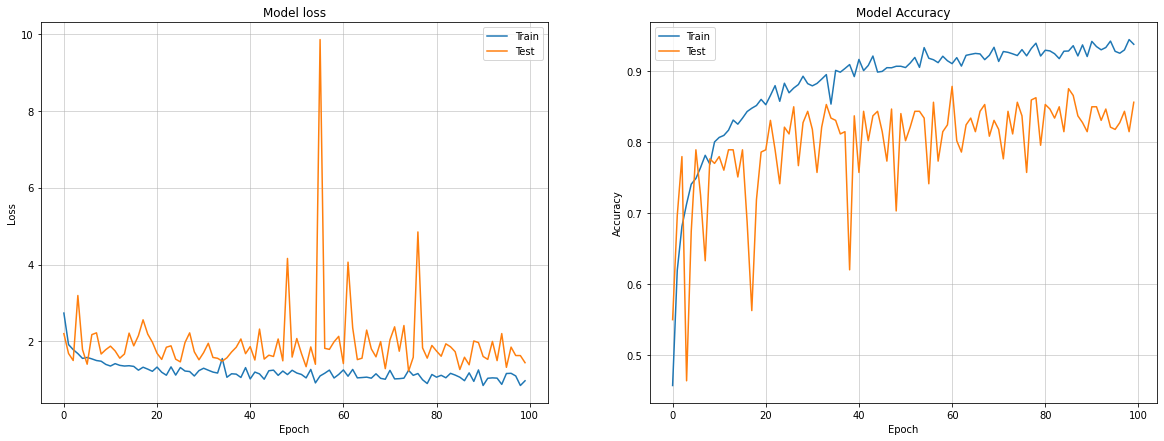

In [52]:
plot_loss_accuracy(history)

## Evaluating Model on Test set

In [53]:
print(f'Model Accuracy: {round(model.evaluate(X_test,y_test,verbose=0)[1],2)*100}%')
print(f'Model AUC: {round(model.evaluate(X_test,y_test,verbose=0)[2],2)}')

Model Accuracy: 81.0%
Model AUC: 0.96


### Classification report

In [31]:
from sklearn.metrics import classification_report

In [32]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(model.predict(X_test),axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.50      0.25      0.33         4
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         1
           4       0.99      1.00      1.00       105
           5       0.98      0.99      0.99       195
           6       0.95      0.89      0.92       247
           7       0.67      0.50      0.57        12
           8       0.57      1.00      0.73         8
           9       0.00      0.00      0.00         1
          10       0.86      0.75      0.80         8
          11       0.92      0.69      0.79        16
          12       0.00      0.00      0.00         1
          13       0.80      0.60      0.69        20
          14       0.57      0.93      0.70        14
          15       0.71      1.00      0.83         5
          16       1.00      1.00      1.00         3
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Predict

In [ ]:
model.predict(X_test[5].reshape((1,) + X_test[5].shape)) , y_test[5]

# Save model

In [ ]:
!mkdir -p /content/drive/MyDrive/lewagon-deepdive/working_environment/03.model_training/models/model_12/new_preproc/cut_5s

save_path=f'/content/drive/MyDrive/lewagon-deepdive/working_environment/03.model_training/models/model_12/new_preproc/cut_5s'

In [ ]:
joblib.dump(model, save_path+ '/model.joblib')

In [ ]:
plot_loss_accuracy(history)
plt.savefig(save_path+ '/plot.png')

In [ ]:
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = models.Model(inputs = model.input, outputs = successive_outputs)

layer_names = [layer.name for layer in model.layers]

layer_name = model.layers[0]

x_list=[X_test[5], X_test[15], X_test[45], X_test[75]]

for j in range(len(x_list)):

  x   = x_list[j].reshape((1,) + x_list[j].shape)
  
  successive_feature_maps = visualization_model.predict(x)

  feature_map =visualization_model.predict(x)[0]
  n_features = feature_map.shape[-1] 

  plt.figure(figsize=(400,100))
  for i in range(1,n_features):
    plt.subplot(48,1,i) 
    x  = feature_map[0, :, :, i]
    plt.imshow(x)
  plt.savefig(save_path +f'/kernels_{j}.png')

In [ ]:
# iterate each sample of X_test, predict, and store predicted index into a numpy array.

ypred_array = np.array([])

for i in range(len(X_test)):
    X = X_test[i]
    X = X[np.newaxis, ...] # to make a 4D
    
    # prediction
    prediction = model.predict(X)
    
    # extract the index with the max value
    predicted_index = np.argmax(prediction, axis=1)
    ypred_array = np.append(ypred_array, predicted_index)

confusion_mtx = confusion_matrix(np.argmax(y_test,axis=1), ypred_array) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=df['species_code'].unique(), yticklabels=df['species_code'].unique(), 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title("Confusion Matrix of CNN")
plt.savefig(save_path + '/confusion_matrix.png', bbox_inches='tight')
plt.show();

In [ ]:
# # roc curve for classes
# fpr = {}
# tpr = {}
# thresh ={}

# name=df['species_code'].unique()
# n_class = 31

# for i in range(n_class):    
#     prediction = model.predict(X_test)
#     predicted_index = np.argmax(prediction, axis=1)
#     fpr[i], tpr[i], thresh[i] = roc_curve(np.argmax(y_test,axis=1), model.predict(X_test)[:,i], pos_label=i)
#     plt.plot(fpr[i], tpr[i], linestyle='--', label=f'Class {name[i]} vs Rest')

# fig=plt.figure(figsize=(15,5))
# plt.title('Multiclass ROC curve')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive rate')
# plt.legend(loc='best')
# plt.savefig(save_path + '/multiclass_ROC.png',dpi=300); 

# Pipeline Demo Day

In [ ]:
# model= joblib.load('/content/drive/MyDrive/lewagon-deepdive/working_environment/03.model_training/models/model_12/cut_5s/model.joblib')

In [ ]:
# audio_pred, code_pred = get_audio_data_and_species_code('/content/drive/MyDrive/lewagon-deepdive/raw_data/external_audio_files/','AC2A_Humpback_Whale_glacier_bay_1.mp3','AC2A',sr=44100)

# tuple_pred= [(audio_pred, code_pred)]

# if len(audio_pred)/44100 < 5:
#   tuple_pred = val_test_split_below_samples(tuple_pred,5,44100)
# else: 
#   tuple_pred = val_test_split_above_samples(tuple_pred,5,44100)

# tuple_pred = get_arrays_from_audio(tuple_pred)

# pred=0

# for i in range(len(tuple_pred)):
#   x= tuple_pred[i][0].reshape((1,) + tuple_pred[i][0].shape)
#   pred += model.predict(np.expand_dims(x,-1))
#   # print(np.expand_dims(x,-1))
#   print(np.expand_dims(x,-1).shape)
#   print(pred)
#   print(pred.shape)
#   break


# pred = pred/len(tuple_pred)
# predicted_class = np.argmax(pred, axis=1)
# print(f"Predicted class: {df.loc[df['species_code'] == df['species_code'].unique()[predicted_class][0], 'common_name'].iloc[0]}")
# print(f'Actual class: Humpback Whale')

# Preprocessing tests

In [ ]:
import librosa
from IPython.display import Audio

In [ ]:
def add_white_noise(signal,noise_factor):
  noise = np.random.normal(0, signal.std(),signal.size)
  augmented_signal = signal + noise * noise_factor
  return augmented_signal

def random_gain(signal, min_gain_factor, max_gain_factor):
  gain_factor= random.uniform(min_gain_factor,max_gain_factor)
  return signal * gain_factor

In [ ]:
signal , sr = librosa.load('/content/drive/MyDrive/lewagon-deepdive/raw_data/watkins_audio_files/AA1A_7801800H.wav')

In [ ]:
%%time
noise_signal = add_white_noise(signal,0.1)

In [ ]:
plt.figure(figsize=(15,5))

librosa.display.waveshow(noise_signal)
plt.title('Signal Waveform with White Noise');

S_noise = librosa.feature.melspectrogram(y=noise_signal, sr=44100) # Compute a mel-scaled spectrogram
S_DB_noise = librosa.power_to_db(S_noise, ref=np.max) # Convert a power spectrogram (amplitude squared) to decibel (dB) units

In [ ]:
librosa.display.specshow(S_DB_noise, x_axis='time',
                         y_axis='mel', sr=44100,
                         fmax=8000);

In [ ]:
Audio(noise_signal, rate=sr)

In [ ]:
plt.figure(figsize=(15,5))

librosa.display.waveshow(signal)
plt.title('Signal Waveform');

In [ ]:
S = librosa.feature.melspectrogram(y=signal, sr=44100) # Compute a mel-scaled spectrogram
S_DB = librosa.power_to_db(S, ref=np.max) 
librosa.display.specshow(S_DB, x_axis='time',
                         y_axis='mel', sr=44100,
                         fmax=8000);

In [ ]:
Audio(signal, rate=sr)

In [ ]:
%%time
gain_signal = random_gain(signal,2,4)

In [ ]:
gain_signal = random_gain(signal,2,4)
S_gain = librosa.feature.melspectrogram(y=gain_signal, sr=44100) # Compute a mel-scaled spectrogram
S_DB_gain = librosa.power_to_db(S_gain, ref=np.max) 
librosa.display.specshow(S_DB_gain, x_axis='time',
                         y_axis='mel', sr=44100,
                         fmax=8000);

In [ ]:
plt.figure(figsize=(15,5))

librosa.display.waveshow(gain_signal)
plt.title('Signal Waveform with Gain');

In [ ]:
Audio(gain_signal, rate=sr)

In [54]:
model= joblib.load('/content/drive/MyDrive/lewagon-deepdive/working_environment/03.model_training/models/model_12/cut_5s/model.joblib')

mypath='/content/drive/MyDrive/lewagon-deepdive/raw_data/external_audio_files/'

from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

for demo_sound in onlyfiles:
  audio_pred,sr = librosa.load(mypath+ demo_sound)

  tuple_pred= [(audio_pred, demo_sound)]

  if len(audio_pred)/44100 < 5:
    tuple_pred = val_test_split_below_samples(tuple_pred,5,44100)
  else: 
    tuple_pred = val_test_split_above_samples(tuple_pred,5,44100)

  tuple_pred = get_arrays_from_audio(tuple_pred)

  pred=0

  for i in range(len(tuple_pred)):
    x= tuple_pred[i][0].reshape((1,) + tuple_pred[i][0].shape)
    pred += model.predict(np.expand_dims(x,-1))
    pred = pred/len(tuple_pred)
    predicted_class = np.argmax(pred, axis=1)
  print(f"Predicted class: {df.loc[df['species_code'] == df['species_code'].unique()[predicted_class][0], 'common_name'].iloc[0]}")
  print(f'Actual class:{demo_sound}')

Predicted class: Humpback whale
Actual class:CC12V_NOAA_Harbor-seal.wav
Predicted class: Sperm whale
Actual class:CC14A_NOAA_Ross-seal.wav
Predicted class: Humpback whale
Actual class:CC12V_Harbor_Seal_glacier_bay_1.wav
Predicted class: Beluga - white whale
Actual class:CC12G_NOAA_Harp-seal.wav
Predicted class: White-beaked dolphin
Actual class:CC6A_NOAA_Crabeater-seal.wav
Predicted class: Grampus - Risseau' s dolphin
Actual class:CC5A_NOAA_Weddell-seal.wav
Predicted class: Spinner dolphin
Actual class:AC2A_Humpback_Whale_glacier_bay_2.wav
Predicted class: Southern right whale
Actual class:AA3A_NOAA_northern-right-whale.wav
Predicted class: Humpback whale
Actual class:AC2A_Humpback_Whale_glacier_bay_3.wav
Predicted class: False killer
Actual class:AC2A_Humpback_Whale_glacier_bay_6.wav
Predicted class: Humpback whale
Actual class:AC2A_NOAA_humpback-whale.wav
Predicted class: Spinner dolphin
Actual class:AC2A_Humpback_Whale_glacier_bay_5.wav
Predicted class: Long-finned pilot
Actual clas

In [21]:
model= joblib.load('/content/drive/MyDrive/lewagon-deepdive/working_environment/03.model_training/models/model_12/new_preproc/uncut_5s/model.joblib')
mypath='/content/drive/MyDrive/lewagon-deepdive/raw_data/Watkins_all_cuts/'

audio_pred,sr = librosa.load(mypath+ 'AA1A_8000100A.wav')

tuple_pred= [(audio_pred, 'AA1A')]

if len(audio_pred)/44100 < 5:
  tuple_pred = val_test_split_below_samples(tuple_pred,5,44100)
else: 
  tuple_pred = val_test_split_above_samples(tuple_pred,5,44100)

tuple_pred = get_arrays_from_audio(tuple_pred)

pred=0

for i in range(len(tuple_pred)):
  x= tuple_pred[i][0].reshape((1,) + tuple_pred[i][0].shape)
  pred += model.predict(np.expand_dims(x,-1))
  pred = pred/len(tuple_pred)
  predicted_class = np.argmax(pred, axis=1)
print(f"Predicted class: {df.loc[df['species_code'] == df['species_code'].unique()[predicted_class][0], 'common_name'].iloc[0]}")
print(f'Actual class: Bowhead whale')

NameError: ignored

In [49]:
'AC2A_Humpback_Whale_glacier_bay_7'.split('_')[1:-1]

['Humpback', 'Whale', 'glacier', 'bay']